In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns;
sns.set()

### Motivating KDE:Histograms

In [2]:
#create a funtion that creates dome data drawn from 2 normal dist
def make_data(N,f=0.3,rseed=1):
    rand=np.random.RandomState(rseed)
    x=rand.randn(N)
    x[int(f*N):]+=5
    return x

x=make_data(1000)

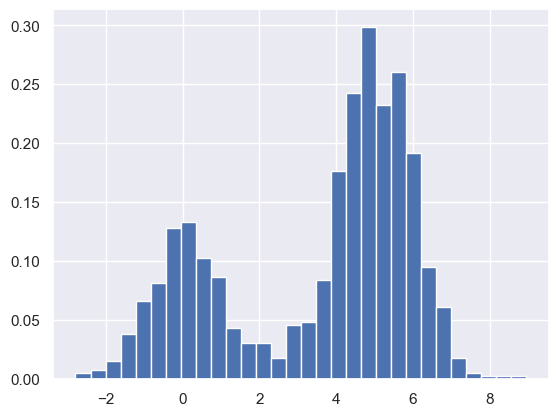

In [5]:
hist=plt.hist(x,bins=30,density=True)

In [10]:
density,bins, patches=hist
widths=bins[1:]-bins[:-1]
(density*widths).sum()

1.0

In [11]:
#the ick about using histograms, watch>>
X=make_data(20)
bins=np.linspace(-5,10,10)

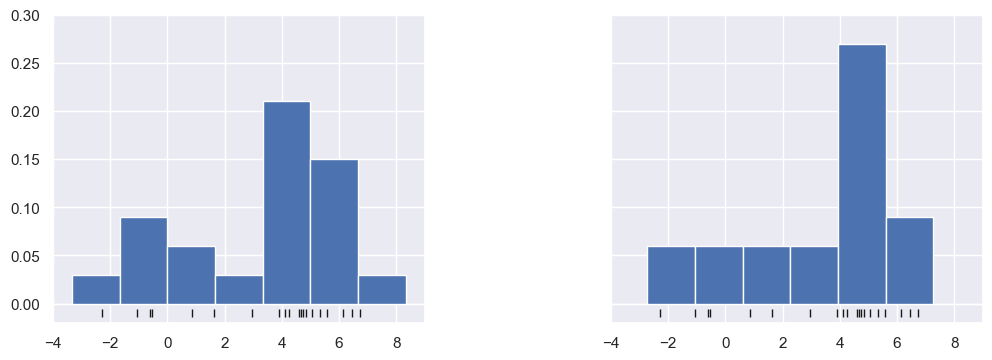

In [14]:
fig, ax=plt.subplots(1,2,figsize=(12,4),
                    sharex=True, sharey=True,
                    subplot_kw={'xlim':(-4,9),
                               'ylim':(-0.02,0.3)})
fig.subplots_adjust(wspace=0.50)

for i,offset in enumerate ([0.0,0.6]):
    ax[i].hist(X,bins=bins+offset, density=True)
    ax[i].plot(X, np.full_like(X,-0.01), '|k',
              markeredgewidth=1)

(-0.2, 8.0)

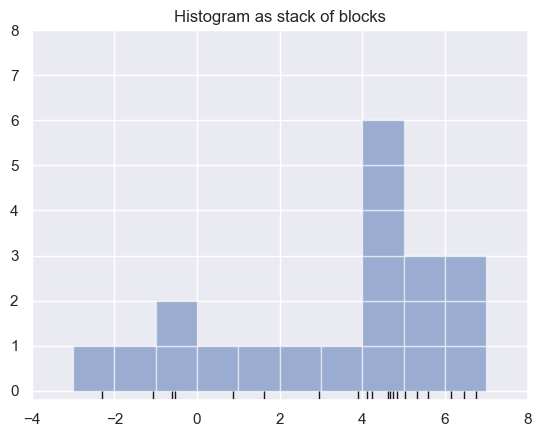

In [16]:
#now, how do you improve on this? 
fig, ax=plt.subplots()
bins=np.arange(-3,8)
ax.plot(X, np.full_like(X, -0.1),'|k',
       markeredgewidth=1)
for count, edge in zip(*np.histogram(X,bins)):
    for i in range(count):
        ax.add_patch(plt.Rectangle((edge,i),1,1, alpha=0.5))
        
ax.set_title('Histogram as stack of blocks')        
ax.set_xlim(-4,8)
ax.set_ylim(-0.2,8)

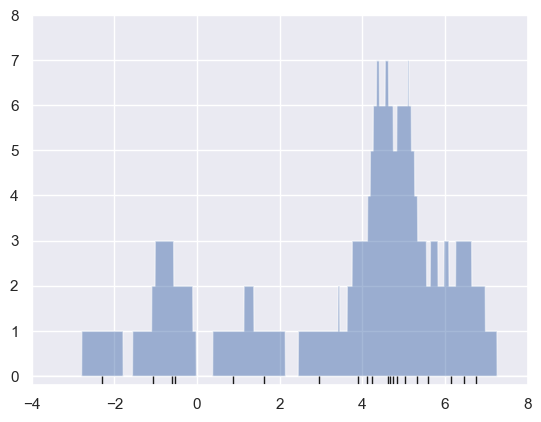

In [18]:
#still not better, But what if, instead of stacking the blocks 
#aligned with the bins, we were to stack the blocks aligned
#with the points they represent?

x_d=np.linspace(-4,8,2000)
density=sum((abs(xi-x_d)<0.5) for xi in X)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(X, np.full_like(X,-0.1),'|k',markeredgewidth=1)

plt.axis([-4,8,-0.2,8]);

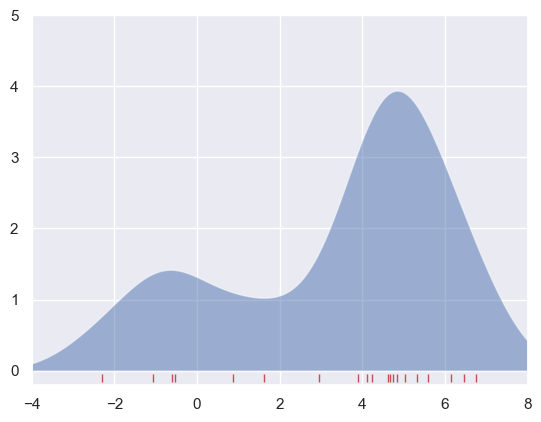

In [21]:
#smoothen the rough edges with a smooth function, like a Gaussian

from scipy.stats import norm
x_d=np.linspace(-4,8,1000)
density=sum(norm(xi).pdf(x_d)for xi in X)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(X, np.full_like(X,-0.1),'|r',markeredgewidth=1)

plt.axis([-4,8,-0.2,5]);

The last two plots are examples of kernel density estimation in one dimension: the
first uses a so-called “tophat” kernel and the second uses a Gaussian kernel. 

### Kernel Density Estimation in Practice

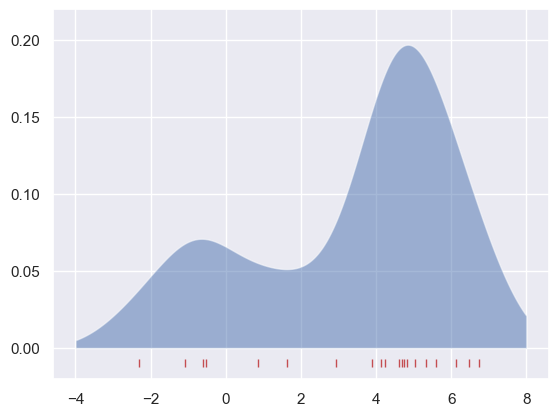

In [23]:
from sklearn.neighbors import KernelDensity

#instantiate and fit the KDE model
kde=KernelDensity(bandwidth=1.0, kernel='gaussian')
kde.fit(X[:, None])

#score_samples return the log of the probability density
logprob=kde.score_samples(x_d[:, None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(X, np.full_like(X,-0.01),'|r', markeredgewidth=1)
plt.ylim(-0.02,0.22);

#### Selecting the bandwidth via cross-validation

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut

bandwidths=10**np.linspace(-1,1,100)
grid=GridSearchCV(KernelDensity(kernel='gaussian'),
                 {'bandwidth':bandwidths},
                 cv=LeaveOneOut())
grid.fit(X[:,None]);

In [28]:
grid.best_params_

{'bandwidth': 1.1233240329780276}

### Example: KDE on a Sphere

In [29]:
from sklearn.datasets import fetch_species_distributions
data=fetch_species_distributions()

#Get matrices/arrays of species IDs and locations
latlon=np.vstack([data.train['dd lat'],
                 data.train['dd long']]).T
species=np.array([d.decode('ascii').startswith('micro')
                 for d in data.train['species']], dtype='int')

URLError: <urlopen error [Errno 11001] getaddrinfo failed>

In [34]:
from mpl_toolkits.basemap import Basemap
from sklearn.datasets import fetch_species_distributions as construct_grids

xgrid,ygrid=construct_grids(data)

#plot coastlines with basemap
m=Basemap(projection='cyl', resolution='c',
         llcrnrlat=ygrid.min(), urcrnrlat=ygrid.max(),
         llcrnrlon=xgrid.min(), urcrnrlon=xgrid.max())
m.drawmapboundary(fill_color='#DDEEFF')
m.fillcontinents(color='#FFEEDD')
m.drawcoastlines(color='gray', zorder=2)
m.drawcountries(color='gray',zorder=2)

#plot locations
m.scatter(latlon[:,0],latlon[:,1], zorder=3, c=cpecies, cmap='rainbow',
         latlon=True);

NameError: name 'data' is not defined

In [35]:
# Set up the data grid for the contour plot
X, Y = np.meshgrid(xgrid[::5], ygrid[::5][::-1])
land_reference = data.coverages[6][::5, ::5]
land_mask = (land_reference > -9999).ravel()
xy = np.vstack([Y.ravel(), X.ravel()]).T
xy = np.radians(xy[land_mask])

# Create two side-by-side plots
fig, ax = plt.subplots(1, 2)
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05)
species_names = ['Bradypus Variegatus', 'Microryzomys Minutus']
cmaps = ['Purples', 'Reds']

for i, axi in enumerate(ax):
    axi.set_title(species_names[i])

    # plot coastlines with Basemap
m = Basemap(projection='cyl', llcrnrlat=Y.min(),
            urcrnrlat=Y.max(), llcrnrlon=X.min(),
            urcrnrlon=X.max(), resolution='c', ax=axi)
m.drawmapboundary(fill_color='#DDEEFF')
m.drawcoastlines()
m.drawcountries()

# construct a spherical kernel density estimate of the distribution
kde = KernelDensity(bandwidth=0.03, metric='haversine')
kde.fit(np.radians(latlon[species == i]))

# evaluate only on the land: -9999 indicates ocean
Z = np.full(land_mask.shape[0], -9999.0)
Z[land_mask] = np.exp(kde.score_samples(xy))
Z = Z.reshape(X.shape)

# plot contours of the density
levels = np.linspace(0, Z.max(), 25)
axi.contourf(X, Y, Z, levels=levels, cmap=cmaps[i])

NameError: name 'xgrid' is not defined

### Example: Not-So-Naive Bayes

In [36]:
from sklearn.base import BaseEstimator, ClassifierMixin

class KDEClassifier(BaseEstimator, ClassifierMixin):
    """Bayesian generative classification based on KDE
    Parameters
    ----------
    bandwidth : float
    the kernel bandwidth within each class
    kernel : str
    the kernel name, passed to KernelDensity
    """
def __init__(self, bandwidth=1.0, kernel='gaussian'):
    self.bandwidth = bandwidth
    self.kernel = kernel

def fit(self, X, y):
    self.classes_ = np.sort(np.unique(y))
    training_sets = [X[y == yi] for yi in self.classes_]
    self.models_ = [KernelDensity(bandwidth=self.bandwidth,
                                  kernel=self.kernel).fit(Xi)
                    for Xi in training_sets]
    self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                       for Xi in training_sets]
    return self

def predict_proba(self, X):
    logprobs = np.array([model.score_samples(X)
                         for model in self.models_]).T
    result = np.exp(logprobs + self.logpriors_)
    return result / result.sum(1, keepdims=True)
 
def predict(self, X):
    return self.classes_[np.argmax(self.predict_proba(X), 1)]

#### The anatomy of a custom estimator

In [39]:
from sklearn.base import BaseEstimator, ClassifierMixin
class KDEClassifier(BaseEstimator, ClassifierMixin):
    """Bayesian generative classification based on KDE
    Parameters
    ----------
    bandwidth : float
    the kernel bandwidth within each class
    kernel : str
    the kernel name, passed to KernelDensity
    """
def __init__(self, bandwidth=1.0, kernel='gaussian'):
    self.bandwidth=bandwidth
    self.kernel=kernel
    
def fit(self,X,y):
    self.classes_=np.sort(np.unique(y))
    training_sets=[X[y==yi] for yi in self.classes_]
    self.models_=[KernelDensity(bandwidth=self.bandwidth,
                              kernel=self.kernel).fit(Xi)
                for Xi in training_sets]
    self.logpriors_=[np.log(Xi.shape[0]/X.shape[0])
                    for Xi in training_sets]
    return self 

In [40]:
label=model.fit(X,y).predict(X)

NameError: name 'model' is not defined

In [41]:
def predict_proba(self, X):
    logprobs = np.vstack([model.score_samples(X)
                          for model in self.models_]).T
    result = np.exp(logprobs + self.logpriors_)
    return result / result.sum(1, keepdims=True)
def predict(self, X):
    return self.classes_[np.argmax(self.predict_proba(X), 1)]


#### Using custom estimator

In [45]:
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV

digits=load_digits()

bandwidths =10**np.linspace(0,2,100)
grid=GridSearchCV(KDEClassifier(),{'bandwidth':bandwidths})
grid.fit(digits.data, digits.target)

scores=[val.mean_validation_score for val in grid.grid_scores_]

TypeError: fit() missing 2 required positional arguments: 'X' and 'y'

In [46]:
plt.semilogx(bandwidths, scores)
plt.xlabel('bandwidth')
plt.ylabel('accuracy')
plt.title('KDE Model Performance')
print(grid.best_params_)
print('accuracy =', grid.best_score_)

NameError: name 'scores' is not defined

In [48]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

cross_val_score(GaussianNB(), digits.data, digits.target).mean()

0.8069281956050759